# Intensive Care Unit Mortality Prediction

In this project I will be exploring data from intensive care unit (ICU) stays in order to identify predictors of in-hospital mortality and create a model to carry out this prediction. The ICU is the area of the hospital where critically ill or injured patients are treated. ICU patients are usually in life-threatening situations, so they are constantly being monitored. Intensive care is extremely prevalent, making up 20% of hospital beds in the U.S.

Because of the critical state of patients as well as the importance of the continuation of care and adequate allocation of resources, a classification model for prediction of patient survival is critical. The diversity of cases and complexity of the human makes a data-less prediction model very difficult, but with a large dataset with many potential predictors, we can try to create a model that can potentially be used to effectively triage patients and determine if someone is ready to be transfered out of the ICU. 



![title](icu.jpg)



# Data

Our data is from the 2012 Computing in Cardiology Challenge. It is composed of records from approximately 12,000 adult ICU stays lasting greater than 48 hours. These data points are all taken from the first 48 hours of the patients' stays.


- ### Time Series
    1. Albumin
    2. ALP (Alkaline phosphatase)
    3. ALT (Alanine transaminase)
    4. AST (Aspartate transaminase)
    5. Bilirubin
    6. BUN (Blood urea nitrogen)
    7. Cholesterol
    8. Creatinine (Serum creatinine)
    9. DiasABP (Invasive diastolic arterial blood pressure)
    10. FiO2 (Fraction inspired O2
    11. GCS (Glasgow Coma Score)
    12. Glucose (Serum glucose)
    13. HCO3 (Serum bicarbonate)
    14. HCT (Hematocrit)
    15. HR (Heart rate)
    16. K (Serum potassium)
    17. Lactate
    18. MG (Serum magnesium)
    19. MAP (Mean arterial blood pressure)
    20. Mech Vent (Mechanical ventilation respiration)
    21. Na (Serum sodium)
    22. NIDiasABP (Non-invasive diastolic arterial blood pressure)
    23. NISysABP (Non-invasive systolic arterial blood pressure)
    24. PaCO2 (Partial pressure of arterial CO2 (mmHg)
    25. PaO2 (Partial pressure of arterial O2)
    26. pH (Arterial pH)
    27. Platelets
    28. RespRate (Respiration rate)
    29. SaO2 (O2 saturation in hemoglobin)
    30. Temp (Temperature)
    31. TropI (Troponin-I)
    32. TropT (Troponin-T_
    33. Urine (Urine output)
    34. WBC (White blood count)
    35. Weight
    
- ### General Descriptors
    1. RecordID
    2. Age
    3. Gender
    4. Height
    5. ICU Type (1. Coronary Care Unit 2. Cardiac Surgery Recovery Unit 3. Medical ICU 4. Surgical ICU)
    6. Weight (kg)

- ### Subsets
    1. Training (4000 patients)
    2. Testing (4000 patients)
    
    

![title](physionet.png)
Data was obtained from Physionet 

In [1]:
from IPython.display import Image, IFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from imblearn.over_sampling import SMOTE
import missingno as ms
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Structure of the Data

Data for each patient is presented in individual time-series .txt files where there are 3 columns: Time, measurement, and value. Descriptors such as height or weight where measurements were not taken are noted as -1 Here is a sample of a raw data file:

In [80]:
df_sample_pt=pd.read_csv('sample_pt_data.txt')
df_sample_pt.tail(15)

,Time,Parameter,Value
258,45:37,HR,84.00
259,45:37,NIDiasABP,56.00
260,45:37,NIMAP,81.33
261,45:37,NISysABP,132.00
262,45:37,RespRate,20.00
263,45:37,Urine,300.00
264,46:37,RespRate,20.00
265,47:37,GCS,15.00
266,47:37,HR,86.00
267,47:37,NIDiasABP,55.00


In this model, we will be looking at the most recent time-series data for each patient, the rationale being that it is likely the most relevant and up to date data available. Here we will derive the most recent value of each measured parameter:

In [4]:
df_sample_recent=pd.DataFrame(df_sample_pt.groupby(['Parameter']).nth([-1]))
sample_recent=pd.Series(df_sample_recent['Value'], df_sample_recent.index)
sample_recent

Parameter
Age               54.00
BUN                8.00
Creatinine         0.70
GCS               15.00
Gender             0.00
Glucose          115.00
HCO3              28.00
HCT               30.30
HR                86.00
Height            -1.00
ICUType            4.00
K                  4.00
Mg                 1.90
NIDiasABP         55.00
NIMAP             79.33
NISysABP         128.00
Na               136.00
Platelets        185.00
RecordID      132539.00
RespRate          23.00
Temp              37.80
Urine            280.00
WBC                9.40
Weight            -1.00
Name: Value, dtype: float64

Outcomes are made of one file (for each set A and B) with the outcomes of each patient. [SAPS-I](https://www.ncbi.nlm.nih.gov/pubmed/6499483) and [SOFA](https://www.ncbi.nlm.nih.gov/pubmed/11594901) are other previously valdiated ICU-predictive scores.

In [5]:
outcomes_a=pd.read_csv('Outcomes-a.txt').groupby('RecordID').nth(-1)
outcomes_a[outcomes_a['Survival']==-1].head(2)

,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival
RecordID,,,,,
132539,0,5,6,1,-1
132540,0,8,16,8,-1


In [6]:
df_all_test=pd.DataFrame()
for filename in os.listdir('set-a/'):
    df_patient=pd.read_csv('set-a/'+filename)
    df_compacted=pd.DataFrame(df_patient.groupby(['Parameter']).nth(-1)) #last when we have multiple measurements of the same parameter
    df_compacted=pd.Series(df_compacted['Value'], df_compacted.index)
    combined=pd.Series(pd.concat([df_compacted, outcomes_a.loc[df_compacted['RecordID']]]), name=df_compacted['RecordID'])
    df_all_test=df_all_test.append(combined)
    
    

In [7]:
df_all_test.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4000 entries, 132592.0 to 141565.0
Data columns (total 47 columns):
Age                  4000 non-null float64
BUN                  3936 non-null float64
Creatinine           3936 non-null float64
GCS                  3936 non-null float64
Gender               4000 non-null float64
Glucose              3887 non-null float64
HCO3                 3924 non-null float64
HCT                  3936 non-null float64
HR                   3937 non-null float64
Height               4000 non-null float64
ICUType              4000 non-null float64
In-hospital_death    4000 non-null float64
K                    3904 non-null float64
Length_of_stay       4000 non-null float64
Mg                   3897 non-null float64
NIDiasABP            3483 non-null float64
NIMAP                3481 non-null float64
NISysABP             3493 non-null float64
Na                   3925 non-null float64
Platelets            3932 non-null float64
RecordID            

# Cleaning Data

Let's rename some vague descriptors:

In [8]:
changed_columns = {'BUN':'Blood Urea Nitrogen', 'HCO3': 'Bicarb', 'HCT': 'Hematocrit',
                  'FiO2': 'Fractional Inspired O2', 'ALP': 'Alkaline Phosphatase',
                  'ALT':'Alanine transaminase', 'AST':'Aspartate Transaminase',
                  'DiasABP':'Diastolic BP Invasive',
                   'NIDiasABP': 'Diastolic BP Non-Invasive',
                   'NIMAP':'MAP Non-Invasive',
                   'MAP':'MAP Invasive', 'NISysABP':'Systolic BP Non-invasive',
                   'SysABP' : 'Systolic BP Invasive', 'Tropl':'Troponin-I', 'Urine':'Urine Output'                
                  }
df_all_test=df_all_test.rename(changed_columns, axis=1)

Let's identify missing data (i.e. heights as -1) and replace with nan:

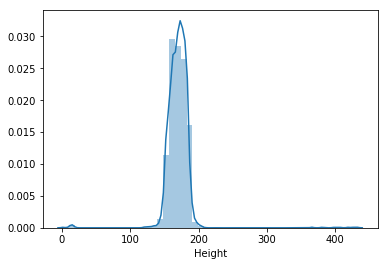

In [9]:
df_all_test['Age']=df_all_test['Age'].replace(-1, np.nan)
df_all_test['Height']=df_all_test['Height'].replace(-1, np.nan)
sns.distplot(df_all_test['Height'].dropna())

There are still some outliers for height that do not make sense... Let's clean those up:

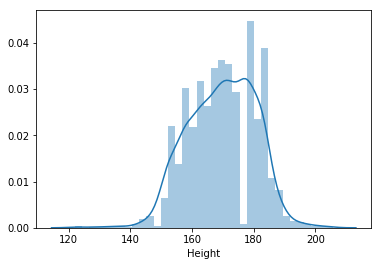

In [10]:
outliers = np.append(df_all_test[df_all_test['Height']<50]['Height'].values,df_all_test[df_all_test['Height']>300]['Height'].values)
if outliers.shape!=0:
    df_all_test['Height']=df_all_test['Height'].replace(outliers, np.nan)
sns.distplot(df_all_test['Height'].dropna())



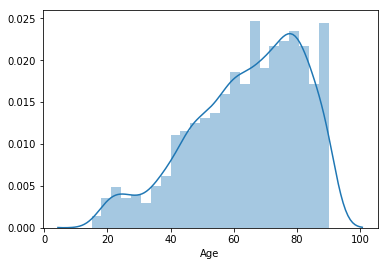

In [11]:
sns.distplot(df_all_test['Age'].dropna())

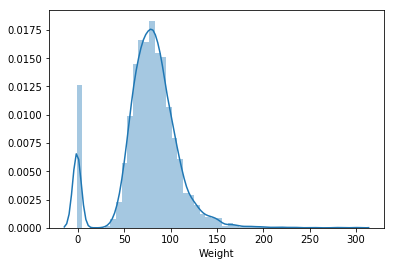

In [12]:
sns.distplot(df_all_test['Weight'].dropna())

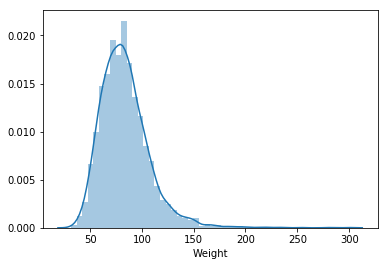

In [13]:
df_all_test['Weight']=df_all_test['Weight'].replace(-1, np.nan)

outliers = df_all_test[df_all_test['Weight']<20]['Weight'].values
if outliers.shape!=0:
    df_all_test['Weight']=df_all_test['Weight'].replace(outliers, np.nan)


sns.distplot(df_all_test['Weight'].dropna())

# Missing data

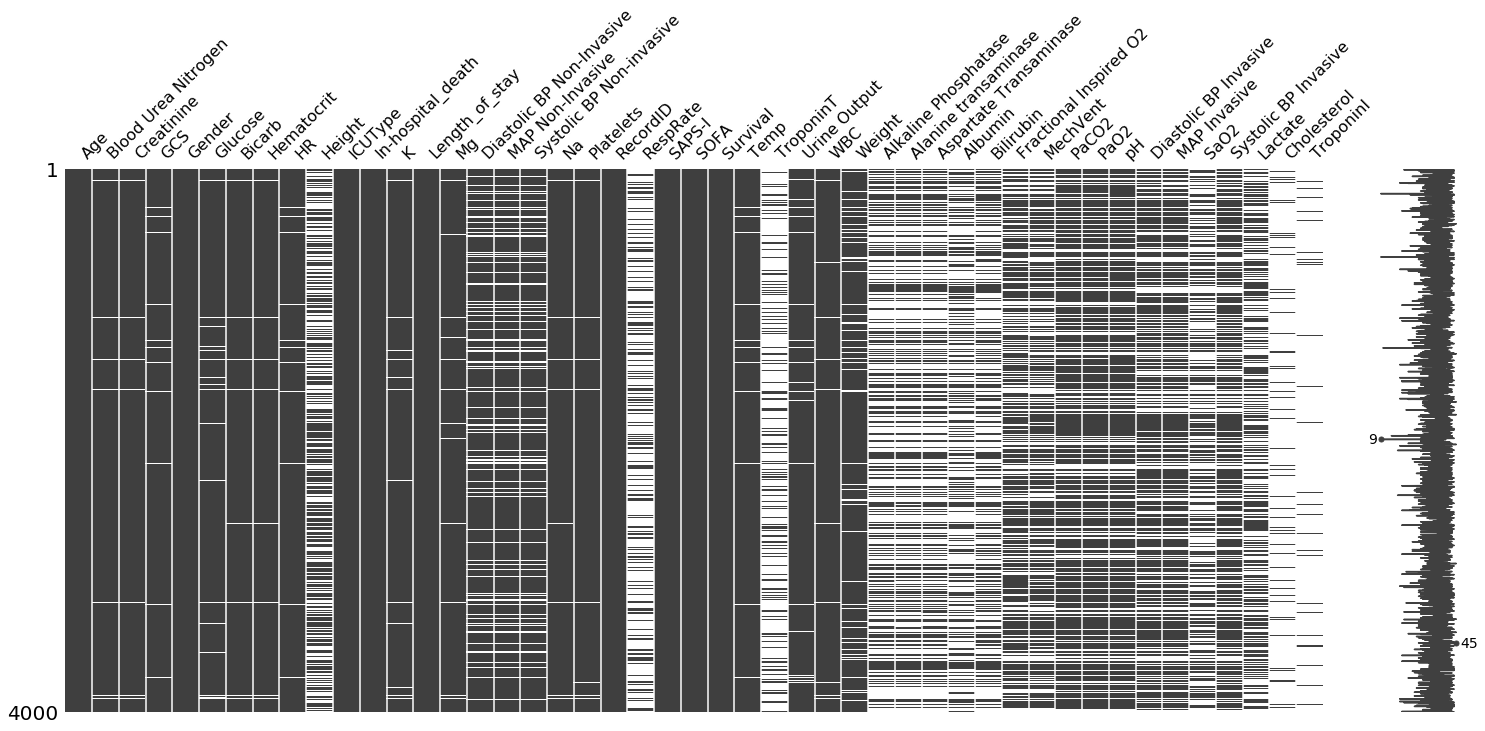

In [14]:
ms.matrix(df_all_test)

For blood pressure measurements, let's merge invasive and non-invasive. Because invasive is [more accurate](https://www.differencebetween.com/difference-between-invasive-and-vs-noninvasive-blood-pressure/#Invasive%20vs%20Noninvasive%20Blood%20Pressure%20in%20Tabular%20Form) we will use invasive when both are present

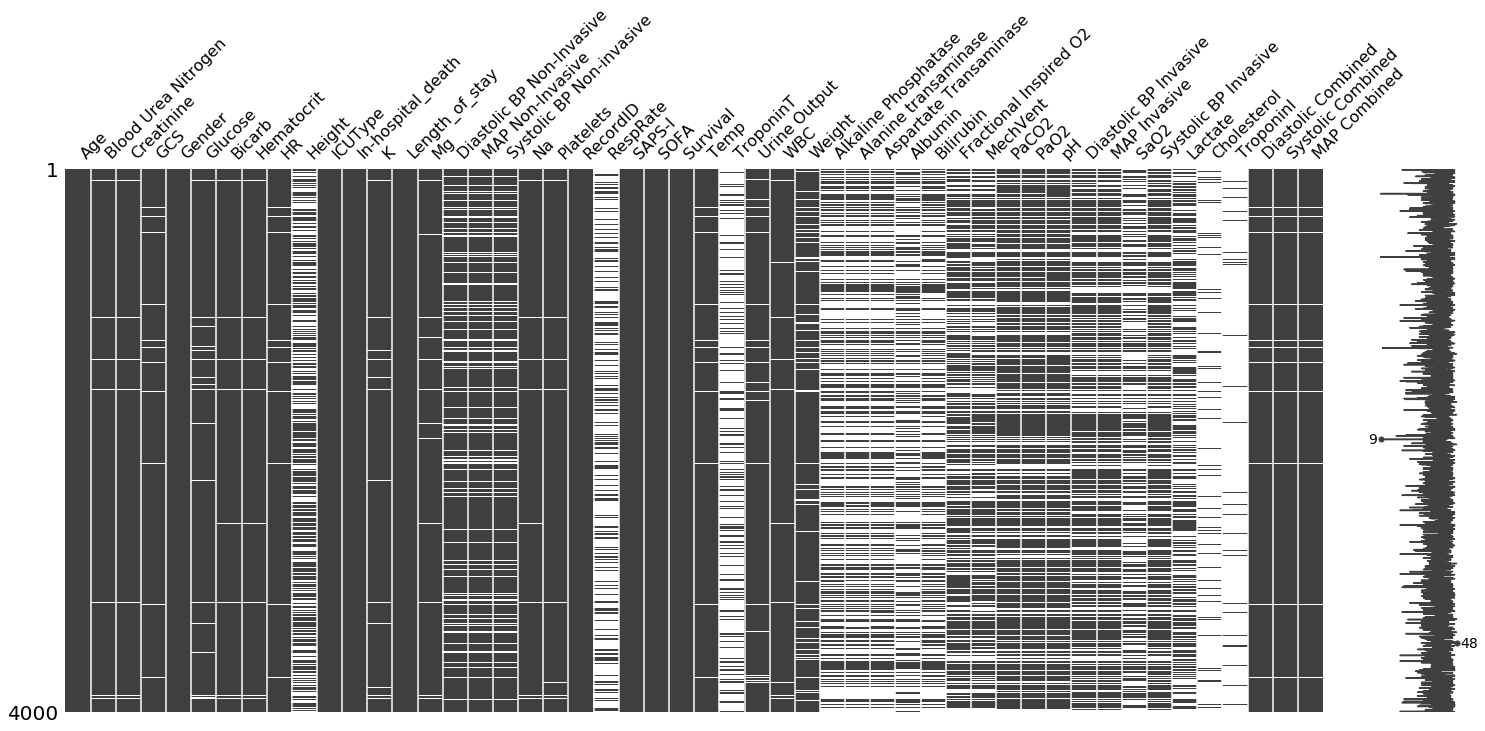

In [15]:
df_all_test['Diastolic Combined'] = df_all_test['Diastolic BP Invasive'].fillna(df_all_test['Diastolic BP Non-Invasive'])
df_all_test['Systolic Combined'] = df_all_test['Systolic BP Invasive'].fillna(df_all_test['Systolic BP Non-invasive'])
df_all_test['MAP Combined'] = df_all_test['MAP Invasive'].fillna(df_all_test['MAP Non-Invasive'])
ms.matrix(df_all_test)




# Narrowing down data

Because we are limited to 4000 patients for the training set, we are going to look at characteristics with near-complete representation in the dataset

In [16]:
df_interest_test=df_all_test[['Age', 'Blood Urea Nitrogen', 'Creatinine', 'GCS', 'Gender', 'Glucose', 'Bicarb', 'Hematocrit',
                    'HR', 'K', 'Mg', 'Na', 'Platelets', 'MAP Combined', 'Temp', 'Urine Output', 'Weight', 'In-hospital_death', 'ICUType']]

df_interest_test.head(5)


,Age,Blood Urea Nitrogen,Creatinine,GCS,Gender,Glucose,Bicarb,Hematocrit,HR,K,Mg,Na,Platelets,MAP Combined,Temp,Urine Output,Weight,In-hospital_death,ICUType
132592.0,35.0,35.0,1.4,15.0,0.0,68.0,17.0,25.3,82.0,4.0,1.8,140.0,286.0,73.67,36.8,100.0,71.8,0.0,3.0
140662.0,42.0,9.0,0.6,15.0,1.0,194.0,30.0,41.7,114.0,4.1,2.3,138.0,169.0,85.00,38.0,80.0,138.1,0.0,3.0
140104.0,61.0,18.0,0.9,15.0,1.0,99.0,30.0,28.8,98.0,4.1,2.0,138.0,221.0,70.00,37.1,300.0,80.0,0.0,2.0
134685.0,53.0,15.0,0.8,12.0,0.0,105.0,27.0,35.4,145.0,3.9,2.2,143.0,248.0,90.00,37.3,60.0,96.1,0.0,4.0
134849.0,46.0,17.0,1.0,15.0,1.0,199.0,25.0,29.0,110.0,3.5,1.9,137.0,216.0,90.33,37.3,25.0,82.0,0.0,3.0


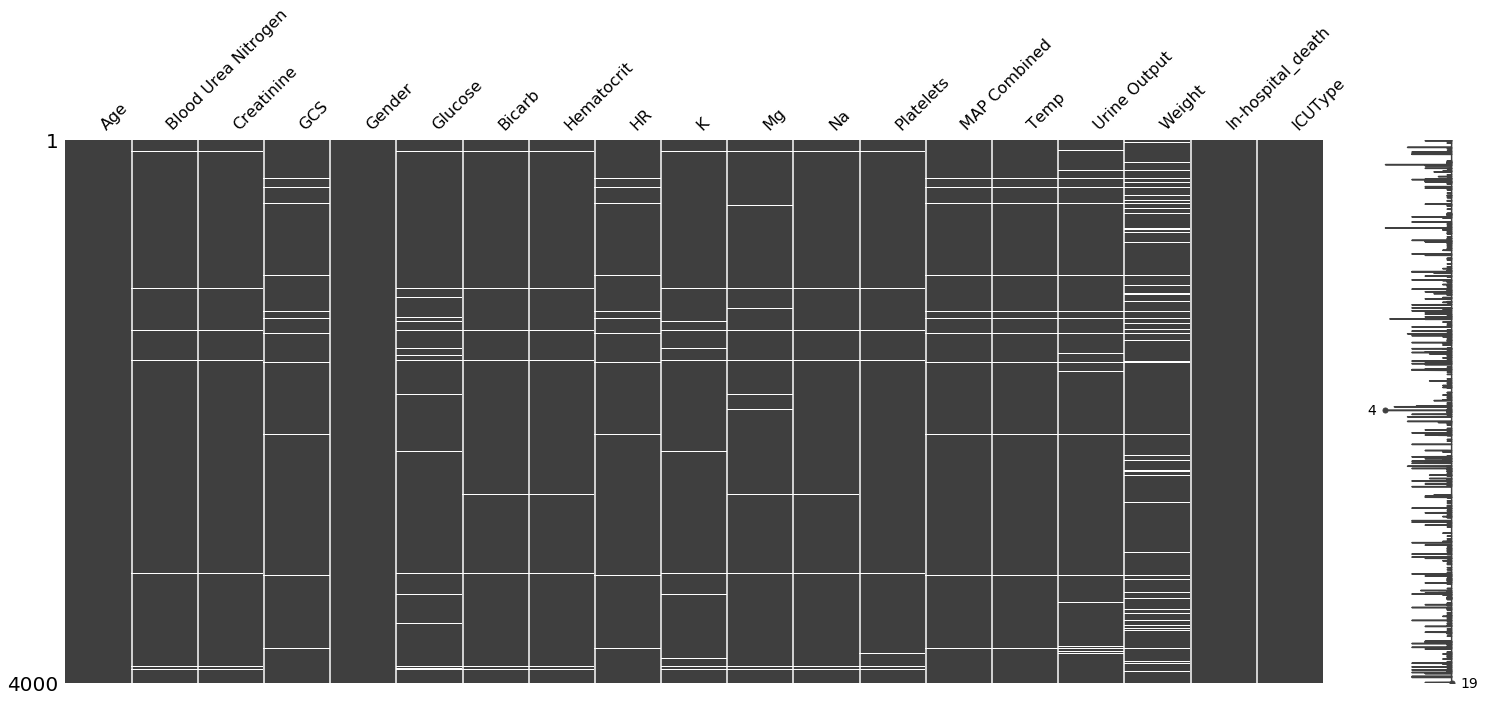

In [17]:
ms.matrix(df_interest_test)

In [18]:
print("Fraction of missing data for the chosen parameters:")
df_interest_test.isnull().sum()/df_interest_test.count()

Fraction of missing data for the chosen parameters:


Age                    0.000000
Blood Urea Nitrogen    0.016260
Creatinine             0.016260
GCS                    0.016260
Gender                 0.000000
Glucose                0.029071
Bicarb                 0.019368
Hematocrit             0.016260
HR                     0.016002
K                      0.024590
Mg                     0.026431
Na                     0.019108
Platelets              0.017294
MAP Combined           0.016002
Temp                   0.016260
Urine Output           0.030131
Weight                 0.082251
In-hospital_death      0.000000
ICUType                0.000000
dtype: float64

We will cut out subjects that are missing any of these measurements:

In [19]:
df_interest_test_dropped=df_interest_test.dropna(how='any')
print("This drop has taken us from ", df_interest_test.shape[0], "patients to", df_interest_test_dropped.shape[0], "patients.")
print(df_interest_test['In-hospital_death'].sum()/df_interest_test.shape[0]*100, "% In-hospital death before dropping data")
print(df_interest_test_dropped['In-hospital_death'].sum()/df_interest_test_dropped.shape[0]*100, "% In-hospital death after dropping data")



This drop has taken us from  4000 patients to 3504 patients.
13.850000000000001 % In-hospital death before dropping data
14.412100456621005 % In-hospital death after dropping data


# Data Exploration

In [20]:
df=df_interest_test_dropped
df.columns

Index(['Age', 'Blood Urea Nitrogen', 'Creatinine', 'GCS', 'Gender', 'Glucose',
       'Bicarb', 'Hematocrit', 'HR', 'K', 'Mg', 'Na', 'Platelets',
       'MAP Combined', 'Temp', 'Urine Output', 'Weight', 'In-hospital_death',
       'ICUType'],
      dtype='object')

### Age

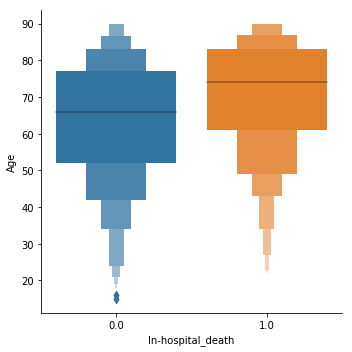

In [21]:
sns.catplot(x='In-hospital_death', y='Age', kind='boxen', data=df)

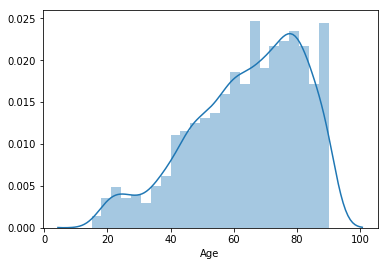

In [22]:
sns.distplot(df_all_test['Age'].dropna())

### Blood Urea Nitrogen

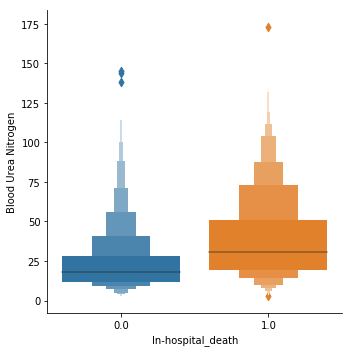

In [23]:
sns.catplot(x='In-hospital_death', y='Blood Urea Nitrogen', kind='boxen',  data=df)

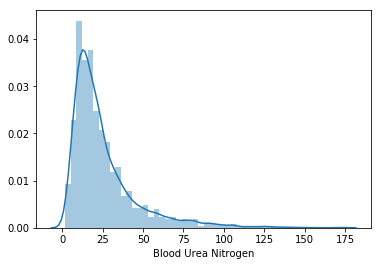

In [24]:
sns.distplot(df_all_test['Blood Urea Nitrogen'].dropna())

### Glucose

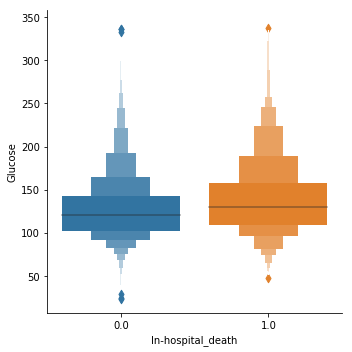

In [25]:
sns.catplot(x='In-hospital_death', y='Glucose', kind='boxen', data=df)

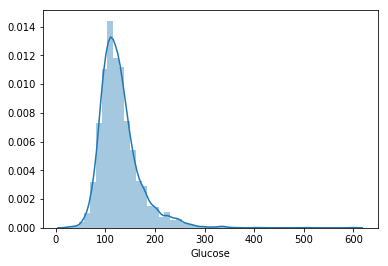

In [26]:
sns.distplot(df_all_test['Glucose'].dropna())

### GCS

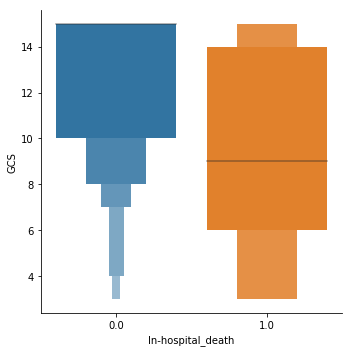

In [27]:
sns.catplot(x='In-hospital_death', y='GCS', kind='boxen', data=df)

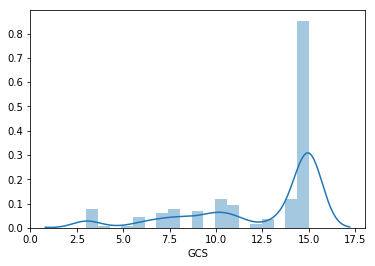

In [28]:
sns.distplot(df_all_test['GCS'].dropna())

### Bicarbonate

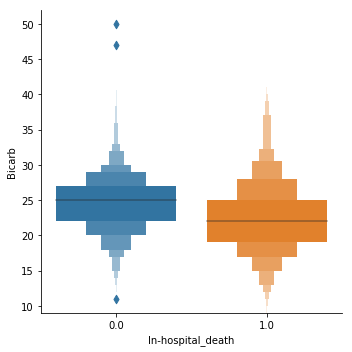

In [29]:
sns.catplot(x='In-hospital_death', y='Bicarb', kind='boxen', data=df)

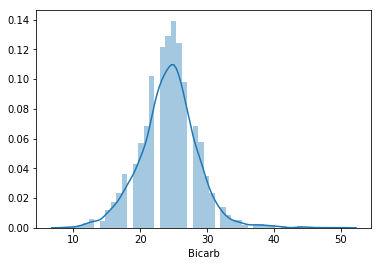

In [30]:
sns.distplot(df_all_test['Bicarb'].dropna())

### Hematocrit

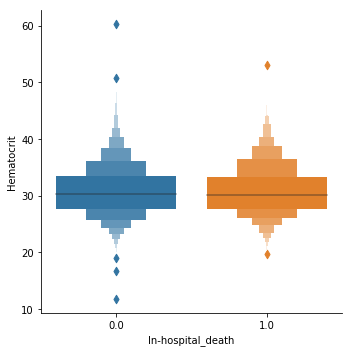

In [31]:
sns.catplot(x='In-hospital_death', y='Hematocrit', kind='boxen', data=df)

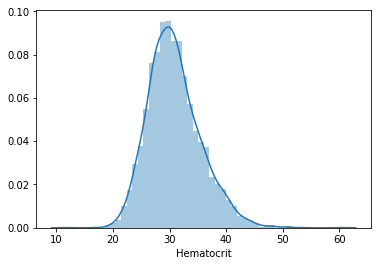

In [32]:
sns.distplot(df_all_test['Hematocrit'].dropna())

### Heart Rate

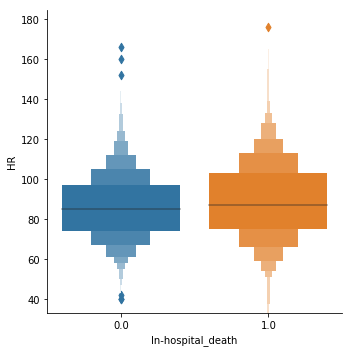

In [33]:
sns.catplot(x='In-hospital_death', y='HR', kind='boxen', data=df)

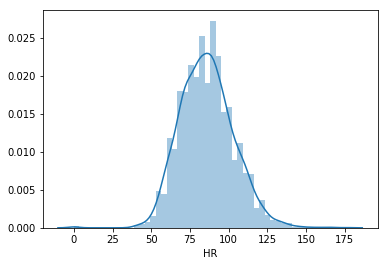

In [34]:
sns.distplot(df_all_test['HR'].dropna())

### Potassium

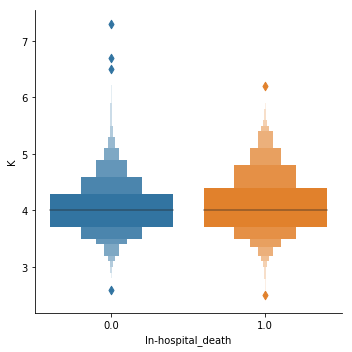

In [35]:
sns.catplot(x='In-hospital_death', y='K', kind='boxen', data=df)

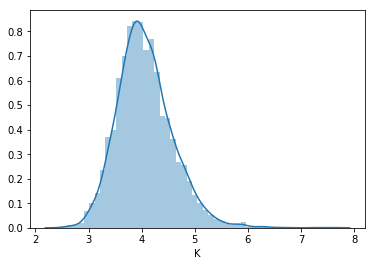

In [36]:
sns.distplot(df_all_test['K'].dropna())

### Sodium

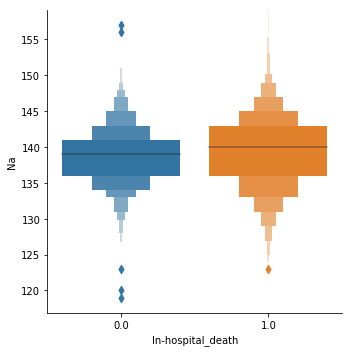

In [37]:
sns.catplot(x='In-hospital_death', y='Na', kind='boxen', data=df)

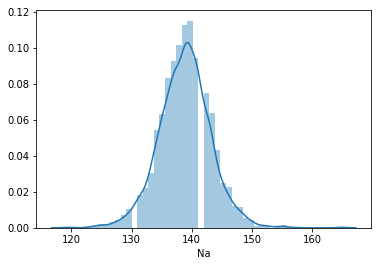

In [38]:
sns.distplot(df_all_test['Na'].dropna())

### Platelets

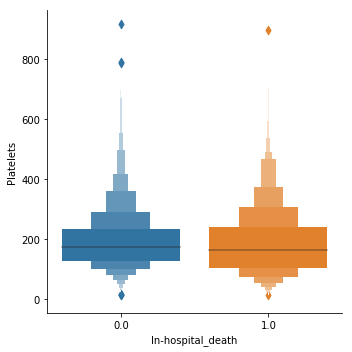

In [39]:
sns.catplot(x='In-hospital_death', y='Platelets', kind='boxen', data=df)

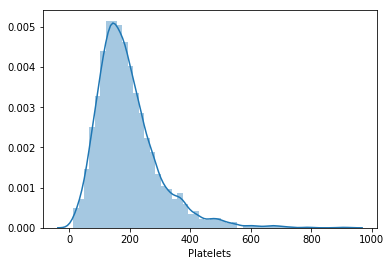

In [40]:
sns.distplot(df_all_test['Platelets'].dropna())

### Blood Pressure

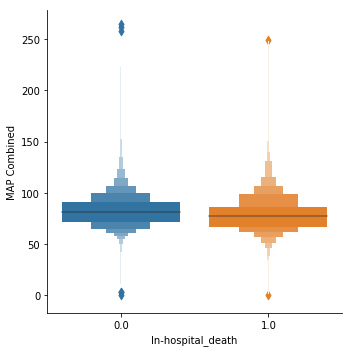

In [41]:
sns.catplot(x='In-hospital_death', y='MAP Combined', kind='boxen', data=df)

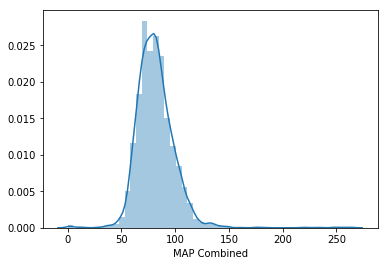

In [42]:
sns.distplot(df_all_test['MAP Combined'].dropna())

### Urine Output

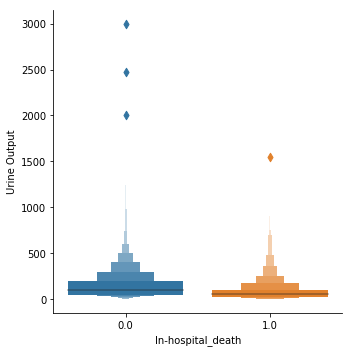

In [43]:
sns.catplot(x='In-hospital_death', y='Urine Output', kind='boxen', data=df)

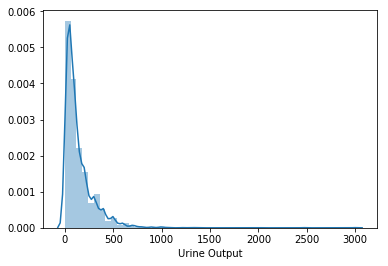

In [44]:
sns.distplot(df_all_test['Urine Output'].dropna())

### Weight

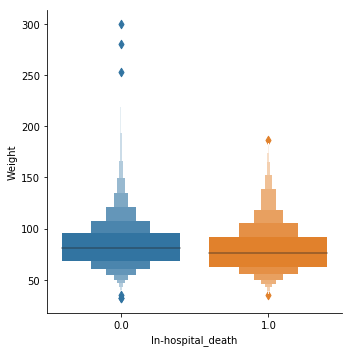

In [45]:
sns.catplot(x='In-hospital_death', y='Weight', kind='boxen', data=df)

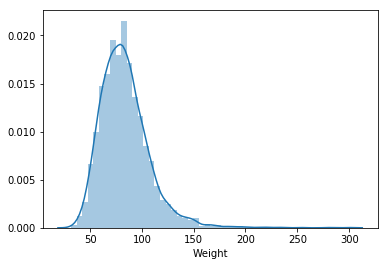

In [46]:
sns.distplot(df_all_test['Weight'].dropna())

# Checking for Correlation

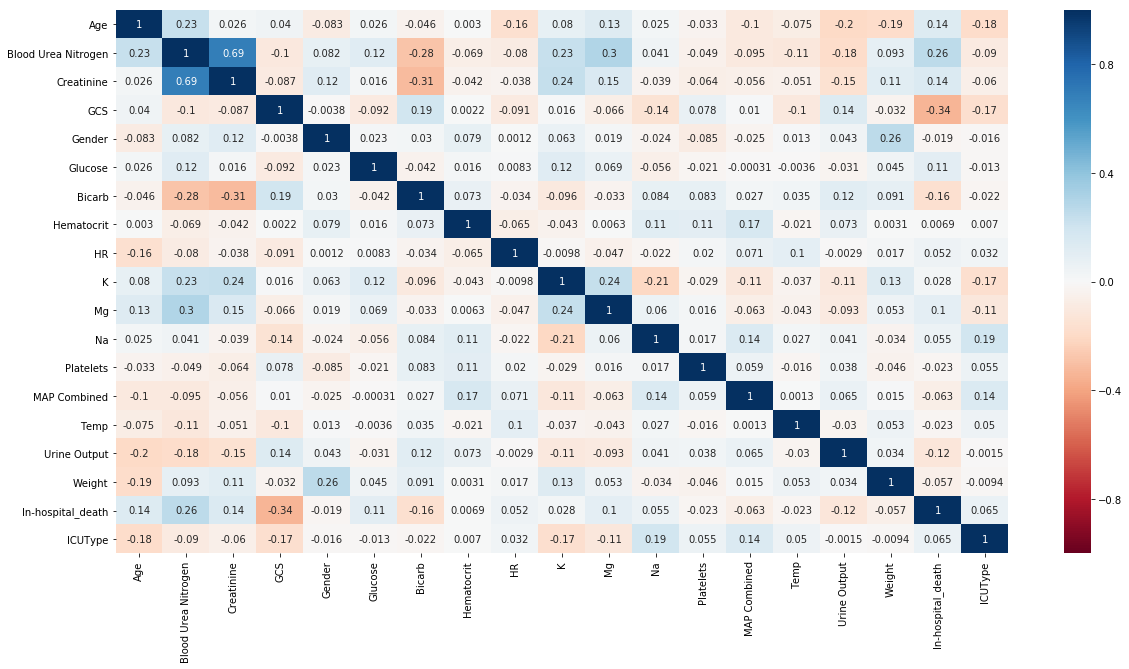

In [47]:
plt.figure(figsize=(20,10))
sns.heatmap(data=df.corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')

The only notable correlation appears to be between Blood Urea Nitrogen and Creatinine. We will be sure to not include both of these variables in the final logistic regression model.

# Creating an initial logistic regression model

In [48]:
df_no_os=df.drop('ICUType', axis=1)
df_no_os=df_no_os.dropna()
df_no_os.shape
X_train = df_no_os.loc[:, df_no_os.columns != 'In-hospital_death']
y_train = df_no_os.loc[:, df_no_os.columns == 'In-hospital_death']

In [50]:
lr_model=sm.Logit(y_train, X_train)
result=lr_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.319358
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      In-hospital_death   No. Observations:                 3504
Model:                          Logit   Df Residuals:                     3487
Method:                           MLE   Df Model:                           16
Date:                Sat, 10 Aug 2019   Pseudo R-squ.:                  0.2256
Time:                        16:27:17   Log-Likelihood:                -1119.0
converged:                       True   LL-Null:                       -1445.0
                                        LLR p-value:                2.236e-128
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0222      0.004      5.872      0.000       0.015       0.030
Bl

In [51]:
cols=['Age', 'Blood Urea Nitrogen', 'GCS', 'Glucose', 'Bicarb', 'HR', 'MAP Combined', 'Urine Output', 'Weight']
X_train=X_train[cols]
y_train=y_train['In-hospital_death']



In [52]:
lr_model=sm.Logit(y_train, X_train)
result=lr_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.321212
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      In-hospital_death   No. Observations:                 3504
Model:                          Logit   Df Residuals:                     3495
Method:                           MLE   Df Model:                            8
Date:                Sat, 10 Aug 2019   Pseudo R-squ.:                  0.2211
Time:                        16:27:22   Log-Likelihood:                -1125.5
converged:                       True   LL-Null:                       -1445.0
                                        LLR p-value:                1.024e-132
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0215      0.003      6.637      0.000       0.015       0.028
Bl

In [53]:
outcomes_b=pd.read_csv('Outcomes-b.txt').groupby('RecordID').nth(-1)
outcomes_b.head(2)

,In-hospital_death,Length_of_stay,SAPS-I,SOFA,Survival
RecordID,,,,,
142675,1,9,27,14,7
142676,0,31,12,1,468


In [54]:
#Loading the test data
df_b=pd.DataFrame()
for filename in os.listdir('set-b/'):
    df_patient_b=pd.read_csv('set-b/'+filename)
    df_compacted_b=pd.DataFrame(df_patient_b.groupby(['Parameter']).mean()) #averages when we have multiple measurements of the same parameter
    df_compacted_b=pd.Series(df_compacted_b['Value'], df_compacted_b.index)
    combined=pd.Series(pd.concat([df_compacted_b, outcomes_b.loc[df_compacted_b['RecordID']]]), name=df_compacted_b['RecordID'])
    df_b=df_b.append(combined)
    


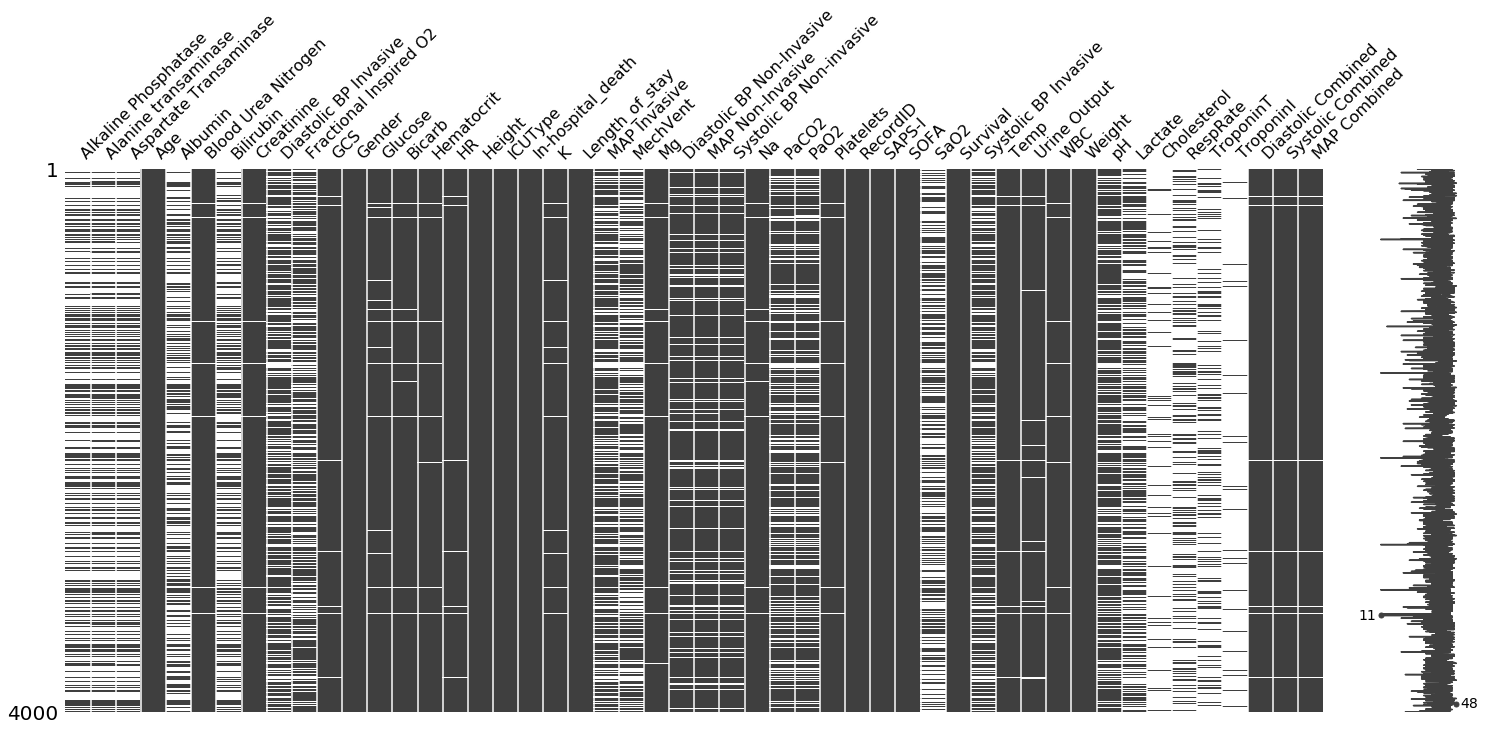

In [55]:
df_b=df_b.rename(changed_columns, axis=1)
df_b['Diastolic Combined'] = df_b['Diastolic BP Invasive'].fillna(df_b['Diastolic BP Non-Invasive'])
df_b['Systolic Combined'] = df_b['Systolic BP Invasive'].fillna(df_b['Systolic BP Non-invasive'])
df_b['MAP Combined'] = df_b['MAP Invasive'].fillna(df_b['MAP Non-Invasive'])
ms.matrix(df_b)

In [56]:
df_b_dropped=df_b[['Age', 'Blood Urea Nitrogen', 'Creatinine', 'GCS', 'Gender', 'Glucose', 'Bicarb', 'Hematocrit',
                    'HR', 'K', 'Mg', 'Na', 'Platelets', 'MAP Combined', 'Temp', 'Urine Output', 'Weight', 'In-hospital_death']]

df_b_dropped.head(2)

,Age,Blood Urea Nitrogen,Creatinine,GCS,Gender,Glucose,Bicarb,Hematocrit,HR,K,Mg,Na,Platelets,MAP Combined,Temp,Urine Output,Weight,In-hospital_death
144404.0,71.0,24.5,0.60,10.538462,1.0,119.000000,24.500000,30.750000,83.145455,4.45,2.1,136.5,505.000,72.977778,37.676923,130.595238,74.200000,0.0
148558.0,76.0,64.5,1.85,10.458333,0.0,156.333333,21.166667,34.414286,61.865979,4.15,1.9,136.0,116.375,71.160494,37.770588,60.050000,78.304124,0.0


In [57]:
df_b_dropped=df_b_dropped.rename(changed_columns, axis=1)
df_b_dropped=df_b_dropped[cols+['In-hospital_death']]
df_b_dropped=df_b_dropped.dropna()
df_b_dropped.head(2)

,Age,Blood Urea Nitrogen,GCS,Glucose,Bicarb,HR,MAP Combined,Urine Output,Weight,In-hospital_death
144404.0,71.0,24.5,10.538462,119.000000,24.500000,83.145455,72.977778,130.595238,74.200000,0.0
148558.0,76.0,64.5,10.458333,156.333333,21.166667,61.865979,71.160494,60.050000,78.304124,0.0


In [58]:
X_test = df_b_dropped[cols].loc[:, df_b_dropped[cols].columns != 'In-hospital_death']
y_test = df_b_dropped.loc[:, df_b_dropped.columns == 'In-hospital_death']
y_test=y_test.values.ravel()

In [59]:
lr_model_sk=LogisticRegression()
lr_model_sk.fit(X_train, y_train)

/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
print('Accuracy of logistic regression:', format(lr_model_sk.score(X_test, y_test)))

Accuracy of logistic regression: 0.8600941422594143


In [61]:
print('The null accuracy of the model is ', max(y_test.mean(), 1-y_test.mean()))

The null accuracy of the model is  0.856694560669456


In [63]:
y_pred=lr_model_sk.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92      3276
         1.0       0.53      0.20      0.30       548

    accuracy                           0.86      3824
   macro avg       0.71      0.59      0.61      3824
weighted avg       0.83      0.86      0.83      3824

Confusion matrix:

[[3177   99]
 [ 436  112]]


# Performance of Initial Model

Despite the seemingly high accuracy of the model (86%), there are clearly issues with predicting deaths. While we see great success in predicting survivorship (97%), we also see very poor performance at predicting mortality (21%). The corresponding null predictiona accuracy was nearly the same as the model's accuracy. We need to improve this performance given that the most important use of this model would be to warn of possible death. 

A likely cause of this poor performance is the ratio of survivors to deaths (~7:1) in the training set, leading to an over-prediction of survivorship in the test set. Because the dataset is relatively small, we will try an oversampling technique (SMOTE) for survivors to enhance the training set.

# Improving the model by oversampling

In [64]:
smote=SMOTE(random_state=0)
X_train_os, y_train_os=smote.fit_sample(X_train, y_train)
X_train_os=pd.DataFrame(data=X_train_os, columns=cols)
y_train_os= pd.DataFrame(data=y_train_os,columns=['In-hospital_death'])

In [65]:
print("length data is ",len(X_train_os))
print("Number of survived in oversampled data",len(y_train_os[y_train_os['In-hospital_death']==0]))
print("Number of died in oversampled data",len(y_train_os[y_train_os['In-hospital_death']==1]))

length data is  5998
Number of survived in oversampled data 2999
Number of died in oversampled data 2999


In [66]:
lr_model_sk2=LogisticRegression()
lr_model_sk2.fit(X_train_os, y_train_os.values.ravel())

/Users/maxreynolds/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
print('Accuracy of logistic regression:', format(lr_model_sk2.score(X_test, y_test)))

Accuracy of logistic regression: 0.6997907949790795


In [68]:
y_pred2=lr_model_sk2.predict(X_test)
print(classification_report(y_test, y_pred2))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred2))

              precision    recall  f1-score   support

         0.0       0.95      0.68      0.80      3276
         1.0       0.30      0.79      0.43       548

    accuracy                           0.70      3824
   macro avg       0.62      0.74      0.61      3824
weighted avg       0.86      0.70      0.74      3824

Confusion matrix:
 [[2244 1032]
 [ 116  432]]


In [77]:
conf_mat=confusion_matrix(y_test, y_pred2)
print('True negative rate ', conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1]))
print('True positive rate ', conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0]))

True negative rate  0.684981684981685
True positive rate  0.7883211678832117


In [70]:
y_pred2_prob=lr_model_sk2.predict_proba(X_test)[:,1]

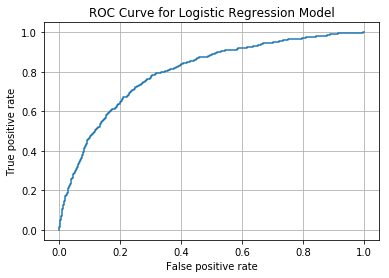

In [71]:
fpr, tpr, thresholds=roc_curve(y_test,y_pred2_prob)
plt.plot(fpr, tpr)
plt.title('ROC Curve for Logistic Regression Model')
plt.xlabel("False positive rate")
plt.ylabel('True positive rate')
plt.grid(True)


In [72]:
print("AUC score: ", roc_auc_score(y_test, y_pred2_prob))

AUC score:  0.7996221134907266


# Model Scoring

Based on the [rules](https://physionet.org/content/challenge-2012/1.0.0/) from the 2012 Computing in Cardiology competition, there are three statistics:

- Sensitivity TP / (TP + FN)
- Positive predictivity TP / (TP+FP)
- Minimum of Sensitivity of Positivity

In [73]:
print("Sensitivity: ", conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0]))
print("Positive predictivity: ", conf_mat[1][1]/(conf_mat[1][1]+conf_mat[0][1]))

Sensitivity:  0.7883211678832117
Positive predictivity:  0.29508196721311475


# Conclusions

The logistic regression technique proved to be effective in providing a measure for predicting In-hospital mortality in ICU patients. A very simple model was created using just 9 commonly measured parameters: age, blood urea nitrogen, GCS, Glucose, Bicarbonate, Heart Rate, Blood Pressure, Urine Output, and Weight. While the mode, at a sensitivity near 0.8, is clearly prone to false positives, it can still serve as good warning sign for potential imminent death for patients who survive at least 48 hours in the ICU.

This analysis was somewhat limited in the parameters tested. Data points such as respiration or mechanical ventilation may have proved helpful but were missing in most of the patients. Further analysis on additional datasets might additional parameters as well as potential interactions (i.e. relationships between different electrolyte levels, etc.). ICU ECG readings could also provide a bevy of information about a patient's state that could prove more useful than somewhat transient heart rate measurements. 




Sources:

- https://www.youtube.com/watch?v=85dtiMz9tSo
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
- https://physionet.org/content/challenge-2012/1.0.0/